## ML data assessment
The first step is to import the the packages I'll be using. I'll start with Pandas for importing the data and initial cleaning of the data. Various parts of Scikit-Learn will become important in the next steps of processing the data.

In [2]:
import numpy as np
import pandas as pd
from src.functions import import_json_to_df

### Data preparation and Exploration
The first step is to import the data into Pandas to prepare it for processing. The function `import_json_to_df` uses `json_normalize` to flatten nested dicts inside the JSON into new columns. An unfortunate side-effect is that the columns are stored as object types when they should be numeric. This import is included in a function in a separate file and imported to keep this file cleaner.

In [3]:
facebook_path = "data-sample/facebook-rotterdam-20170131.json"
factual_path = "data-sample/factual-rotterdam-20170207.csv"
google_path = "data-sample/google-rotterdam-20170207.json"

df_facebook = import_json_to_df(facebook_path)
df_factual = pd.read_csv(factual_path)
df_google = import_json_to_df(google_path)

Changing columns with NaN values to numeric has the unintended consequence that long integer values are changed to float and subject to floating-point errors. Skipping this step for now.

In [4]:
# Some features were tagged as a numeric type and could be converted
#fb_numeric_columns = df_facebook.columns[df_facebook.columns.str.contains('numberLong')]
#df_facebook[fb_numeric_columns] = \
#    df_facebook[fb_numeric_columns].apply(pd.to_numeric)

Not all of the data represents entities located in Rotterdam, NL. For now, this doesn't have much affect on the data (less than 10 out of 14516 entries), but could be important later.

In [5]:
df_facebook[(df_facebook['location_country'] 
             != 'Netherlands') & (df_facebook['location_country'].notnull())][['name', 'location_country']]

,name,location_country
4024,"Rotterdam, Limpopo, South Africa",South Africa
7650,Recovery Sports Grill,United States
7677,Bricklayers Pub and Pizzeria,United States
7715,Rotterdam Mall Cinema,United States
8299,"Rotterdam, Eastern Cape, South Africa",South Africa
8309,Rotterdam (New York),United States
9894,Rotterdam Elks Lodge #2157,United States
12541,Entertainment Express,United States
13493,Planet Fitness,United States


Looking at the `.info()` for each set can give some insight into what data is available - how many features have `NaN` values, and how much of the data is populated. Some of the numerical data could be filled in, and a separate feature could be used to track which values were originally `NaN`. Or the data can be filtered to only include available values. Columns with no data can safely be dropped (preferrably in the import stage).

In [6]:
df_facebook.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14516 entries, 0 to 14515
Data columns (total 135 columns):
__timestamp_$numberLong                         14516 non-null object
__timestamp_basic_$numberLong                   14498 non-null object
__timestamp_detail_$numberLong                  14478 non-null object
__timestamp_insights_$numberLong                8059 non-null object
__timestamp_photos_$numberLong                  8059 non-null object
about                                           10329 non-null object
affiliation                                     41 non-null object
artists_we_like                                 2 non-null object
attire                                          159 non-null object
awards                                          608 non-null object
band_interests                                  1 non-null object
band_members                                    1 non-null object
best_page_id                                    1046 non-null object
be

In [7]:
df_factual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53828 entries, 0 to 53827
Data columns (total 30 columns):
factual_id            53828 non-null object
name                  53828 non-null object
address               51429 non-null object
address_extended      11 non-null object
po_box                0 non-null float64
locality              53828 non-null object
region                53828 non-null object
post_town             0 non-null float64
admin_region          0 non-null float64
postcode              50253 non-null object
country               53828 non-null object
tel                   50529 non-null object
fax                   9401 non-null object
latitude              53828 non-null float64
longitude             53828 non-null float64
neighborhood          24950 non-null object
website               23815 non-null object
email                 1019 non-null object
category_ids          47589 non-null object
category_labels       47589 non-null object
chain_name            0

In [8]:
df_google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91242 entries, 0 to 91241
Data columns (total 32 columns):
address_components                 91242 non-null object
adr_address                        91242 non-null object
formatted_address                  91242 non-null object
formatted_phone_number             66517 non-null object
geometry_location_lat              91242 non-null float64
geometry_location_lng              91242 non-null float64
geometry_viewport_northeast_lat    76375 non-null float64
geometry_viewport_northeast_lng    76375 non-null float64
geometry_viewport_southwest_lat    76375 non-null float64
geometry_viewport_southwest_lng    76375 non-null float64
icon                               91242 non-null object
id                                 91242 non-null object
international_phone_number         66517 non-null object
loc_coordinates                    91242 non-null object
loc_type                           91242 non-null object
name                          

Only the factual data set claims to have duplicate records. These often appear to be locations in a chain, so different instances of the same business and not necessarily duplicated information. None of the records are complete duplicates. In this sense, all the data sets contain duplicate values (a search using `df_google[df_google['name'].str.contains('AMRO')]` confirms this).

In [9]:
df_factual[df_factual['name'].str.contains('Zeetuin')] 

,factual_id,name,address,address_extended,po_box,locality,region,post_town,admin_region,postcode,...,chain_name,chain_id,hours,hours_display,existence,_org_filename,_org_filedate,_imported,__main_category_id,__hash
37721,f033fad0-94f3-4f9e-b8f0-beaa60f93fbf,Zeetuin Kinderdagverblijf De,Statenweg 123/A,NaN,NaN,Rotterdam,Zuid-Holland,NaN,NaN,3039 HK,...,NaN,NaN,NaN,NaN,0.6,nl_places.factual.v3_49.1484024731.tab,10/01/2017 06:05:31,31/01/2017 13:03:44,23,641a864ad64a8ec8e25206725ff3be5c
50373,7f048f80-7986-4ffd-80ba-8a07c2aac163,Zeetuin Kinderdagverblijf De,Schiewg 147d-149a,NaN,NaN,Rotterdam,Zuid-Holland,NaN,NaN,3038 AN,...,NaN,NaN,NaN,NaN,0.6,nl_places.factual.v3_49.1484024731.tab,10/01/2017 06:05:31,31/01/2017 13:03:44,23,a3f98044255d2eba1276a1a1fa34e857


### Geolocation Data
Each of the data sets contains geolocation data (latitude and longitude), this provides a good point for crossreferencing data. We can start by using the location to find what else is located nearby. The first step is plotting locations. The packages `matplotlib` and `sklearn` will be useful here.

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

%matplotlib inline

The first step is plotting the location latitude and longitude for each item in the data (choosing the Facebook data because it's smallest). Using an alpha value of .4 lets us see where the points are stacked on top of each other. In this case, the majority appear in a cluster to the right. Points outside this cluster are likely wrong. One example is for a place called 'Soulbrothers' that claims to be in Rotterdam, NL, but shows coordinates for Las Vegas, NV. Some cleaning of the data would be required to resolve this.

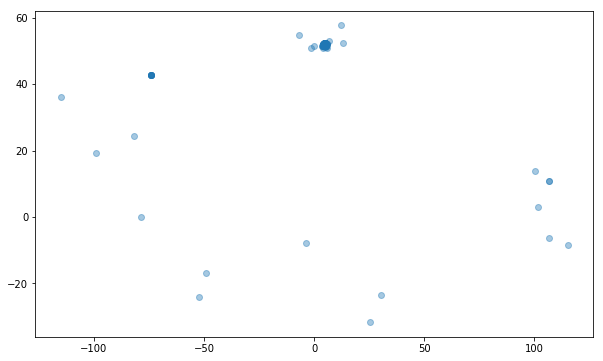

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
loc_scatter = ax.scatter(df_facebook['location_longitude'], df_facebook['location_latitude'], alpha=.4)

plt.show()

The data from Google has better coordinate data. The scale of the plot has a tighter range, and the clustering around Rotterdam is much more visible. There are fewer points that need to be fixed or explained before use.

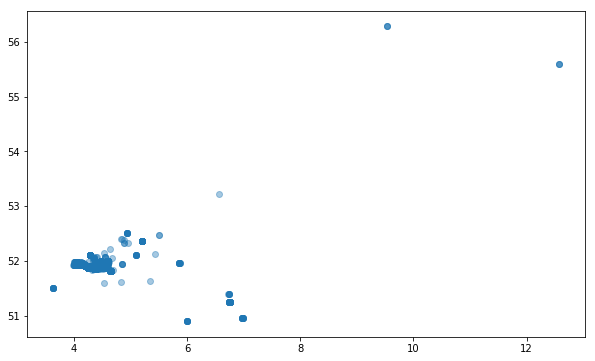

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
loc_scatter = ax.scatter(df_google['geometry_location_lng'], df_google['geometry_location_lat'], alpha=.4)

plt.show()

Ideally, any points outside a range that defines the boundaries of Rotterdam, NL, would be identified and corrected or simply eliminated from the data. The remaining points could then be mapped onto a map of Rotterdam and used to identify popular areas, or identify similar locations based on similarity in their characteristics (location, opening hours, type of business, etc). It can be seen that the shapes become recognizable once the outliers are removed.

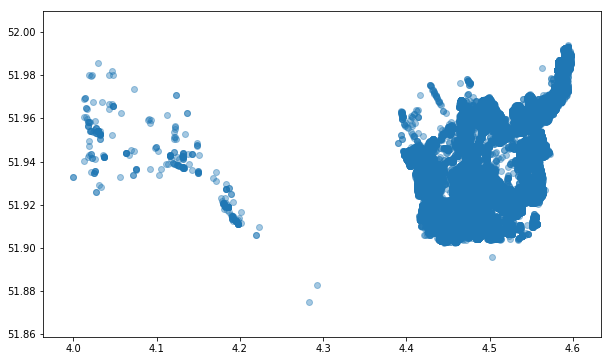

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
loc_scatter = ax.scatter(
    df_google['geometry_location_lng'].iloc[:50000], 
    df_google['geometry_location_lat'].iloc[:50000], 
    alpha=.4)

plt.show()

Clustering can make the data representation more efficient and do a better job of showing overlap in denser locations. It can be tempting to use k-means to group locations around k centroids on the map. However, k-means algorithms are not very robust for geo-spatial data. DBSCAN from sklearn is considered a better option.

In [14]:
coords = df_google.as_matrix(columns=['geometry_location_lat', 'geometry_location_lat'])
loc_clusters = DBSCAN(eps=.0001, min_samples=10, n_jobs=-1).fit(coords)
unique_labels = set(loc_clusters.labels_)
len(unique_labels)

46

The algorithm has created 46 unique groupings based on the spatial data. Borrowing heavily from the [SkLearn demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html) we could use these labels as a mask for plotting the locations. This method has an additional advantage of being able to remove some of the noise mentioned previously. Individual points far outside the main body of the points won't register. It also decides the appropriate number of clusters from the paramaters and can run multiple jobs at once, reducing the time for processing.

### Text Analysis

Spacy allows for sophisticated, robust, and fast text analysis and natural language processing. Spacy offers a number of [tutorials](https://spacy.io/docs/usage/) on basic usage that cover the preliminary steps of things like entity recognition. The standard models are available for English, German, and French. Work is being done on models for the Dutch language, but Spacy also allows for the training of custom models for use in a pipeline.

In [15]:
import spacy
nlp = spacy.load('en') # this assumes `python -m spacy download en` has been run after installing Spacy
doc = nlp(df_facebook['description'].iloc[14474])

Once in a document is loaded in, the model is applied and many of the features of the model are immediately trained and available for use. This requires the suitable model for the text being used, but should work as well on a small text as it does on a larger text. The results are only as good as the quality of the model, but the ability to use custom models allows for specialization to types of text an new languages.

In [16]:
df_facebook['description'].iloc[14474]

'Rotterdam a booming business city full of opportunities; and with that it needs a proper party scene providing you with the proper accompanying entertainment.\n\nElise is there to welcome you to the actual nightlife in Rotterdam! She will organize THE international party celebrating the beginning and end of your studies of each term. She will be showing you a refreshing and innovative way to party like a king in THE city of the Netherlands! Be surprised by the new innovative concepts Elise will show you; allowing you to create experiences you have never had before.\n\nDrink in style, party with class and show her what you got!\n\n“When I’m good, I’m good…but when I’m bad I’m better”\n'

In [17]:
for word in doc:
    print(word.text, word.lemma, word.lemma_, word.tag, word.tag_, word.pos, word.pos_)

Rotterdam 277080 rotterdam 475 NNP 94 PROPN
a 506 a 460 DT 88 DET
booming 314988 booming 467 JJ 82 ADJ
business 1088 business 474 NN 90 NOUN
city 1962 city 474 NN 90 NOUN
full 1171 full 467 JJ 82 ADJ
of 510 of 466 IN 83 ADP
opportunities 2832 opportunity 477 NNS 90 NOUN
; 620 ; 454 : 95 PUNCT
and 512 and 458 CC 87 CCONJ
with 548 with 466 IN 83 ADP
that 514 that 460 DT 88 DET
it 757862 -PRON- 479 PRP 93 PRON
needs 730 need 493 VBZ 98 VERB
a 506 a 460 DT 88 DET
proper 2650 proper 467 JJ 82 ADJ
party 978 party 474 NN 90 NOUN
scene 3747 scene 474 NN 90 NOUN
providing 1721 provide 490 VBG 98 VERB
you 757862 -PRON- 479 PRP 93 PRON
with 548 with 466 IN 83 ADP
the 501 the 460 DT 88 DET
proper 2650 proper 467 JJ 82 ADJ
accompanying 141781 accompanying 467 JJ 82 ADJ
entertainment 4765 entertainment 474 NN 90 NOUN
. 453 . 453 . 95 PUNCT


 517 

 485 SP 101 SPACE
Elise 85730 elise 475 NNP 94 PROPN
is 536 be 493 VBZ 98 VERB
there 608 there 481 RB 84 ADV
to 504 to 486 TO 92 PART
welcome 3471 welcom

The model also provides entity recognition that can be trained to recognize new entities relatively easily. As can be seen here, the model does need some additional training. It reads the name Elise as an organization, and reads 'THE' as the lead into organizations as well. Originally, I classified the inclusion of the name Elise under `ORG` for arganization as an error. However, it turns out the namee of the organization is *Elise Events* and SpaCy may be picking up on that in the usage.

In [18]:
for word in doc:
    print(word.text, word.ent_iob, word.ent_type_)

Rotterdam 3 GPE
a 2 
booming 2 
business 2 
city 2 
full 2 
of 2 
opportunities 2 
; 2 
and 2 
with 2 
that 2 
it 2 
needs 2 
a 2 
proper 2 
party 2 
scene 2 
providing 2 
you 2 
with 2 
the 2 
proper 2 
accompanying 2 
entertainment 2 
. 2 


 2 
Elise 3 ORG
is 2 
there 2 
to 2 
welcome 2 
you 2 
to 2 
the 2 
actual 2 
nightlife 2 
in 2 
Rotterdam 3 GPE
! 2 
She 2 
will 2 
organize 2 
THE 3 ORG
international 1 ORG
party 2 
celebrating 2 
the 2 
beginning 2 
and 2 
end 2 
of 2 
your 2 
studies 2 
of 2 
each 2 
term 2 
. 2 
She 2 
will 2 
be 2 
showing 2 
you 2 
a 2 
refreshing 2 
and 2 
innovative 2 
way 2 
to 2 
party 2 
like 2 
a 2 
king 2 
in 2 
THE 3 GPE
city 1 GPE
of 1 GPE
the 2 
Netherlands 3 GPE
! 2 
Be 2 
surprised 2 
by 2 
the 2 
new 2 
innovative 2 
concepts 2 
Elise 3 ORG
will 2 
show 2 
you 2 
; 2 
allowing 2 
you 2 
to 2 
create 2 
experiences 2 
you 2 
have 2 
never 2 
had 2 
before 2 
. 2 


 2 
Drink 2 
in 2 
style 2 
, 2 
party 2 
with 2 
class 2 
and 2 
show 2 
her 2 

Spacy also uses pretrained, 300-dimensional vectors using the GloVe algorithm. Vectors are available for individual tokens and for whole documents. If the standard vectors are not suitable, it is easy to import a new set using custom training on a corpus.

In [19]:
print(doc.vector)
print(doc[3].vector)

[  2.87487078e-02   1.34127095e-01  -1.12616926e-01  -6.46263063e-02
   8.59907344e-02  -3.01089697e-02   1.48141594e-03  -7.15659410e-02
  -1.24937808e-02   2.04432034e+00  -2.37107277e-01   2.97395550e-02
   2.59523708e-02  -6.27263403e-03  -6.42994940e-02  -6.35967702e-02
  -8.19167346e-02   1.03017926e+00  -2.26013482e-01  -3.39418538e-02
   1.18925851e-02  -6.36380017e-02  -5.37270419e-02  -4.31634523e-02
   7.66084471e-04   3.37663628e-02  -3.61130796e-02  -3.44188213e-02
  -3.88343376e-03  -7.62464702e-02  -4.15372383e-03   5.64913452e-02
  -6.15795404e-02   8.77584144e-02   6.45118356e-02  -7.07166642e-02
   1.45631954e-02   2.75556110e-02  -6.77631423e-02  -8.33967030e-02
   1.33263329e-02   6.09413683e-02  -1.26259737e-02  -1.07860029e-01
   7.08614429e-03   1.04662098e-01  -1.21576585e-01  -1.55950263e-02
   2.07074992e-02  -2.74955705e-02  -3.50871272e-02   4.83535379e-02
   2.76877098e-02  -1.31209493e-02   4.47620787e-02   3.22623439e-02
   1.44080622e-02  -6.28291294e-02

Using word embedding vectors allows for similarity comparisons. Here we can see that 'better' (3rd token from the end of the document) is more similar to 'good' (12th from the end) than it is to bad (6th from the end). These similarities can also be found for the whole texts in our data. This would allow for finding similar text descriptions within the cluster based on locality described above to find locations with in an area that have similar descriptions. If a company found their product to be successful at a location that highlights its party atmosphere and connection to the nightlife, this could be a way for them to find similar locations within an area that already has a number of locations near each other.

In [20]:
print(doc[-3].similarity(doc[-12]))
print(doc[-3].similarity(doc[-6]))

0.817664783783
0.67329133779


Spacy has been designed to work well with other packages (including SKLearn). Other algorithms such as TfIdf could be imported and used to find important terms from descriptions. The ability to train and import new models means that you can start with the pretrained models, create a working pipeline, and then continue to improve it by adding more accurate models. These models can then be combined with the clustering algorithms described previously to find characterisitcs of areas based on proximity or other values. These could be further defined by filtering locations based on on other features such as opening times or specializations such as 'coffee' or 'breakfast'. These levels of specification could allow for a finer grained approach to finding new locations for products. It would also be flexible enough to take into account descriptions provided by the locations themselves, or their customers, and compare them to product descriptions or characterisitcs seen as desireable by the owners of the products (ie, if the company wants to focus on a particcular kind of location).

### Apply NLP to descriptions

#### Use vector embedding to analyze document similarity

Use SpaCy to create an `nlp` object for each text description in the Facebook dataframe. Then use the similarity method on one of the objects to compare it to the others (the default for SpaCy is cosine similarity). First, convert all the text in records that have a text description (about 30 seconds for 6588 texts using `nlp.pipe()`). Then save several of the NLP objects as references for our search. Finally, calculate which other descriptions are most similar to the reference documents.

In [21]:
from src.functions import apply_nlp_to_column, find_other_documents

df_facebook['description_nlp'] = apply_nlp_to_column(df_facebook, 'description')

nlp_elise = nlp(df_facebook['description'].iloc[14474])
nlp_iweek = nlp(df_facebook['description'].iloc[14466])
nlp_mangrove = nlp(df_facebook['description'].iloc[5])

sim_elise = find_other_documents(nlp_elise, df_facebook)
sim_iweek = find_other_documents(nlp_iweek, df_facebook)
sim_mangrove = find_other_documents(nlp_mangrove, df_facebook)

Validating the results can be difficult. We can print out the text for each reference item and see that they are each getting a unique set of related descriptions. If necessary, the cosine similarity could also be printed, to see the expected level of similarity. The real problem with this implementation is that the models are are trained for English language texts. As a result, I have chosen only English descriptions as reference documents. The results show how important this training is - all the results were also written in English.

In [22]:
print(df_facebook['name'].iloc[14474])
print(df_facebook['description'].iloc[14474])
print(sim_elise)

Elise Events
Rotterdam a booming business city full of opportunities; and with that it needs a proper party scene providing you with the proper accompanying entertainment.

Elise is there to welcome you to the actual nightlife in Rotterdam! She will organize THE international party celebrating the beginning and end of your studies of each term. She will be showing you a refreshing and innovative way to party like a king in THE city of the Netherlands! Be surprised by the new innovative concepts Elise will show you; allowing you to create experiences you have never had before.

Drink in style, party with class and show her what you got!

“When I’m good, I’m good…but when I’m bad I’m better”

                        name  \
3783            Panos Pianos   
9927    Hostel Ani & Haakien   
12542     VGilst Photography   
3184         Roffa Mon Amour   
9868    Food & Love Catering   
3049         Turn Up Tuesday   
11881  Blends Carnival Group   
14280              SunSmiles   
12565       

In [23]:
print(df_facebook['name'].iloc[14466])
print(df_facebook['description'].iloc[14466])
print(sim_iweek)

Investment Week
The B&R Investment Week is aimed at bringing students all across The Netherlands in touch with professionals from the financial industry. This is done through lectures, workshops, hedge fund and private equity case competitions and the B&R Investment Symposium. The B&R Investment Week covers a wide range of different sectors  of the financial industry such as trading, private equity and investing.

Lectures are aimed at providing unique insights from financial professionals. There is also room for questions in these lectures. Workshops on the other hand provide you with the opportunity to interact intensively with leading companies from the financial industry.

The case competitions focus on Hedge Funds and Private Equity and give you the opportunity to work closely under the supervision of professionals from the alternative investments industry.
                                                    name  \
13504                            Robeco Asset Management   
11241

In [24]:
print(df_facebook['name'].iloc[5])
print(df_facebook['description'].iloc[5])
print(sim_mangrove)

Mangrove
We have designed and built award-winning campaigns, websites, and apps for some of the Netherland’s most iconic organisations. We strive to simplify digital for their customers and help them get the most out of their investments. 
                                 name  \
8162                             Ranj   
7867                     Openprovider   
4928                          Label A   
11785                     Give a Bike   
7987                   Zwaar Contrast   
6080                 Ibnbaazbookstore   
3506   Marlow Offshore Netherlands BV   
2640                         img-plus   
11008      Turing Society - Rotterdam   
827                  Superuse-Studios   

                                             description  
8162   We are &ranj, a world-class serious gaming com...  
7867   We believe we constantly have to reinvent ours...  
4928   Label A is the technical brain behind successf...  
11785  Give a bike’s goal is to let anyone in the wor...  
7987   Hi the

##### Investment Week Comparison
Here is the description for *Investment Week* for comparison with the description of *Robeco Asset Management*. We can see similar themes of finance and advice. These businesses are clearly in related industries.

In [25]:
print(df_facebook['name'].iloc[14466])
print(df_facebook['description'].iloc[14466])

Investment Week
The B&R Investment Week is aimed at bringing students all across The Netherlands in touch with professionals from the financial industry. This is done through lectures, workshops, hedge fund and private equity case competitions and the B&R Investment Symposium. The B&R Investment Week covers a wide range of different sectors  of the financial industry such as trading, private equity and investing.

Lectures are aimed at providing unique insights from financial professionals. There is also room for questions in these lectures. Workshops on the other hand provide you with the opportunity to interact intensively with leading companies from the financial industry.

The case competitions focus on Hedge Funds and Private Equity and give you the opportunity to work closely under the supervision of professionals from the alternative investments industry.


In [26]:
print(df_facebook['name'].iloc[13504])
print(df_facebook['description'].iloc[13504])

Robeco Asset Management
Robeco offers a broad range of investment strategies to a wide range of clients all over the world. We believe that our scientific approach sets us apart and helps us to maximize returns and minimize risk for our clients. This means we can better serve our clients (in this case for professional investors only). Whether you’re an institution in need of a complete fiduciary management service, a bank looking for a pooled fund as an investment for private investors or a family office looking to outsource portfolio management responsibilities, we’re here with a solution at hand.
 
We’ve been around for over 80 years, over which time we’ve consistently assessed trends and developments with the long term in mind. We were one of the first companies to grasp the importance of sustainability investing, and were an early proponent of quantitative research. The search for the themes of tomorrow goes on: we are currently moving ahead in fields such as factor investing and i

##### Mangrove Comparison
The text for *Mangrove* is very short, and may even be too short for proper comparison. The description for *Ranj* has been returned as the most similar text. *Ranj* appears to be primarily a gaming company, however both texts emphasize the impact of their companies and the focus they have on developing solutions.

In [27]:
print(df_facebook['name'].iloc[5])
print(df_facebook['description'].iloc[5])

Mangrove
We have designed and built award-winning campaigns, websites, and apps for some of the Netherland’s most iconic organisations. We strive to simplify digital for their customers and help them get the most out of their investments. 


In [28]:
print(df_facebook['name'].iloc[8162])
print(df_facebook['description'].iloc[8162])

Ranj
We are &ranj, a world-class serious gaming company located in Rotterdam, Hamburg and Kuala Lumpur. We believe that positive behavioral change can be best achieved through play. Under the vision “Together we build a brighter future” we aim to have measurable impact on the lives of millions of people. We strive to exceed expectations and dare to be out of the ordinary. This is reflected in the unusual, creative solutions we provide. In each project, we challenge clients to combine behavioral change with play. We are not only game fanatics at heart, but a real partner on behavioral change.  
 
We create serious games to help organizations with a variety of issues like complex behavioral change, engaged learning, self-management and knowledge sharing. We provide the client in two ways – high end boutique games that are carefully designed according to the individual demand, or powerful white-label games that can easily be adjusted to the client’s look and feel. We measure the impact of

#### Use vector matrices to find key words in documents
Using tf-idf to weight words in documents based on how often they occur (aand penalizing them if they occur in too many documents), can be an easy way to find some of the words that may be more important to meaning of the document. These wights will be defined for each term in each document. We can store a weight for the relationship of each word to each document in a sparse matrix. Most words will appear in fewer than half the documents, so most word-document intersections will be empty. The matrix uses integer indexes that reference the position of the word in the vocabulary (sorted). Here, the vocabulary has been limited to 1000 words.

In [29]:
from src.functions import spacy_docs_to_df_tfidf, top_n_doc_tokens
df_tfidf, tfidf_vocabulary = spacy_docs_to_df_tfidf(df_facebook)

Using a small text from the location descriptions, we have a list of words sorted by importance (most important first). The list is smaller than the limit of 10, meaning only some of the words were available in the vocabulary. The text follows for comparison with the word list.

In [30]:
top_n_doc_tokens(doc_idx=5, df_tfidf=df_tfidf, vocab=tfidf_vocabulary, max_tokens=10)

array(['organisation', 'customer', 'build', 'help', 'design', 'website'],
      dtype='<U16')

In [31]:
df_facebook.loc[5]['description']

'We have designed and built award-winning campaigns, websites, and apps for some of the Netherland’s most iconic organisations. We strive to simplify digital for their customers and help them get the most out of their investments. '

This process is also language agnostic - it trains on the words in the document set and calculates their importance based on how often they appear in the documents. It can be noted here that the organization name is not in the list - the way the terms are weighted based based on occurences across a range of documents makes it unlikely that organization name and other words specific to the document will appear - in fact, they should not appear. The tf-idf function for scikit-learn includes a list of stop-words for English that helps eliminate words that contribute less to the meaning of the document. It does not include on for Dutch. Adding a list for Dutch would improve the results here - words like `heen` really should not appear in the list (**note: tf-idf creates a list of words that may be useful as stop-words**).

In [32]:
top_n_doc_tokens(doc_idx=18, df_tfidf=df_tfidf, vocab=tfidf_vocabulary, max_tokens=10)

array(['jongeren', 'rotterdam', 'wijken', 'geloven', 'straat', 'heen',
       'ondersteunen', 'enige', 'vrijwilliger', 'kennen'],
      dtype='<U16')

In [33]:
df_facebook.loc[18]['description']

'Wat willen we doen in Rotterdam?\nDichterbij jongeren komen! Dat is het verlangen van Youth for Christ Rotterdam. Al sinds 2001 zoeken we jongeren op waar ze zijn. We geloven dat alle Rotterdamse jongeren mensen om zich heen nodig hebben die hen hoop geven voor de toekomst en door wie ze Jezus te leren kennen en voor Hem zullen kiezen. \n\nActiviteiten\nYouth for Christ Rotterdam is bekend geworden van het jongernwelzijnswerk van The Mall met jongeren ‘van de straat’.  Rotterdam was altijd een vruchtbare broedplaats voor nieuwe vormen om jongeren te bereiken. Het welzijnswerk van The Mall, het meidenwerk en ook de straatbijbel vinden hun oorsprong in Rotterdam.\nOp dit moment is het jongerencentrum van The Mall in de Millinxbuurt ons enige uitvoerende jongerenwerk in de stad. \nDaarnaast zijn we met YfC Rotterdam druk bezig vrijwilligers en kerken te verbinden en te ondersteunen in het opzetten van jongerenwerk in verschillende wijken van Rotterdam.\n'

Borrowing heavily from [Sklearn](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-topics-extraction-with-nmf-lda-py) we can use Latent Dirichlet Allocation (LDA) to some some basic topic modelling across the descriptions. The number of topics and iterations are kept small for this example to make processing facter. The random state is also set to keep the results consistent as this will be run multiple times.

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(df_tfidf.to_coo()) #this is a workaround to eliminate NaN entries, should consider using tfidf object
print_top_words(lda, tfidf_vocabulary, n_top_words)

Topic #0:
station pedicure line metro massage rotterdam 00u open centraal city locate west south euro initiatief minuten center direct connect erasmus
Topic #1:
rotterdam wijk maas zuid rotterdamse ligt kerk museum nieuwe café park meter gebouw werden centrum gebouwd charlois kralingen meet oude
Topic #2:
yoga hillegersberg trendy begrip basis rotterdam mooie jaar modern class body massage gratis doel woman goede studio meet hair onze
Topic #3:
restaurant cafe chinese foto gerechten facebookpagina alle place rotterdam welkom vind dutch night zakelijk korte groene heel donderdag soorten moderne
Topic #4:
beauty pagina facebook salon behandelingen hair gevestigd gratis welkom beste rotterdam make parkeren professionele opleidingen nederlands vindt nederlandse centrum merk
Topic #5:
meet onze rotterdam alle kunt waar wordt nl maken jaar staat eigen producten nieuwe mensen www informatie graag zoal bieden
Topic #6:
marketing club fitness media communicatie social online webshop therapie sp

Some work needs to be done refining this process, but already we can see the lists contain words that appear related to each other. Topic #9 seems to contain words that are related to time, for example. A larger number of topics would probably be more useful. The number of iterations while fitting the model also affects the quality of the topics.

#### Use Support Vector Classifier (SVC) to predict categories from Facebook descriptions
The Facebook data contains a category classification for the descriptions. If these are consistent, the tfidf vectors and possibly the LDA results may be useful in predicting a category for each description based purely on the information given in the text. 